In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!tar -xzvf "drive/MyDrive/AI_Datasets/CORL2017ImitationLearningData.tar.gz"

Mounted at /content/drive
AgentHuman/SeqTrain/data_05787.h5
AgentHuman/SeqTrain/data_06279.h5
AgentHuman/SeqTrain/data_06466.h5
AgentHuman/SeqVal/data_00302.h5
AgentHuman/SeqTrain/data_04260.h5
AgentHuman/SeqTrain/data_03875.h5
AgentHuman/SeqVal/data_00115.h5
AgentHuman/SeqTrain/data_04073.h5
AgentHuman/SeqTrain/data_03688.h5
AgentHuman/SeqTrain/data_05364.h5
AgentHuman/SeqTrain/data_04207.h5
AgentHuman/SeqTrain/data_03902.h5
AgentHuman/SeqTrain/data_04870.h5
AgentHuman/SeqTrain/data_06435.h5
AgentHuman/SeqTrain/data_06889.h5
AgentHuman/SeqTrain/data_04683.h5
AgentHuman/SeqTrain/data_05017.h5
AgentHuman/SeqTrain/data_05974.h5
AgentHuman/SeqTrain/data_04496.h5
AgentHuman/SeqTrain/data_06172.h5
AgentHuman/SeqTrain/data_04100.h5
AgentHuman/SeqTrain/data_03715.h5
AgentHuman/SeqTrain/data_06306.h5
AgentHuman/SeqVal/data_00244.h5
AgentHuman/SeqTrain/data_06119.h5
AgentHuman/SeqTrain/data_05070.h5
AgentHuman/SeqTrain/data_05814.h5
AgentHuman/SeqTrain/data_06782.h5
AgentHuman/SeqTrain/data_052

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import h5py
import tensorflow as tf
from keras.utils.vis_utils import plot_model

sep = "/"
data_dir = "AgentHuman"
data_train = data_dir + sep + "SeqTrain"
data_val = data_dir + sep + "SeqVal"

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,AvgPool2D,Dropout,Flatten,Activation,BatchNormalization,MaxPool2D,Lambda
from tensorflow.keras.initializers import TruncatedNormal, Constant
from tensorflow.keras import regularizers
from tensorflow.keras.activations import tanh
from tensorflow.keras.losses import MeanAbsolutePercentageError

In [ ]:
dimx = 88
dimy = 200

In [ ]:
def image_module(input):
  '''
  Args:
    input (tensor) -- batch of images or features

  Returns:
    (tensor) max pooled and batch-normalized features of the input 
  '''
  conv_dropout = 0.2
  dense_dropout = 0.5

  x = Conv2D(filters=32,kernel_size=(5, 5), strides = 2, activation = "ReLU")(input)
  x = Dropout(conv_dropout)(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters=32,kernel_size=(3,3), activation = "ReLU")(x)
  x = Dropout(conv_dropout)(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters=64,kernel_size=(3,3), strides = 2, activation = "ReLU")(x)
  x = Dropout(conv_dropout)(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters=64,kernel_size=(3,3), activation = "ReLU")(x)
  x = Dropout(conv_dropout)(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters=128,kernel_size=(3,3), strides = 2, activation = "ReLU")(x)
  x = Dropout(conv_dropout)(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters=128,kernel_size=(3,3), activation = "ReLU")(x)
  x = Dropout(conv_dropout)(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters=256,kernel_size=(3,3), activation = "ReLU")(x)
  x = Dropout(conv_dropout)(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters=256,kernel_size=(3,3), activation = "ReLU")(x)
  x = Dropout(conv_dropout)(x)
  x = BatchNormalization()(x)

  x = Flatten()(x)
  x = Dense(512, activation = "ReLU")(x)
  x = Dropout(dense_dropout)(x)
  x = Dense(512, activation = "ReLU")(x)
  x = Dropout(dense_dropout)(x)

  return x

In [ ]:
def speed_module(input):
  '''
  Args:
    input (tensor) -- batch of speeds

  Returns:
    (tensor) batch-normalized features of the input 
  '''
  dense_dropout = 0.5
  x = Dense(128, activation = "ReLU")(input)
  x = Dropout(dense_dropout)(x)
  x = Dense(128, activation = "ReLU")(x)
  x = Dropout(dense_dropout)(x)
  return x

In [ ]:
input_img = tf.keras.layers.Input(shape=(dimx, dimy, 3))
input_speed = tf.keras.layers.Input(shape=(1,))

img_features = image_module(input_img)

speed_features = speed_module(input_speed)

combined = tf.keras.layers.concatenate([img_features, speed_features])
x = Dense(512)(combined)
x = Dense(3)(x)

model = tf.keras.Model(inputs=[input_img, input_speed], outputs= x)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 88, 200, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 42, 98, 32)   2432        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 42, 98, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 42, 98, 32)  128         ['dropout[0][0]']            

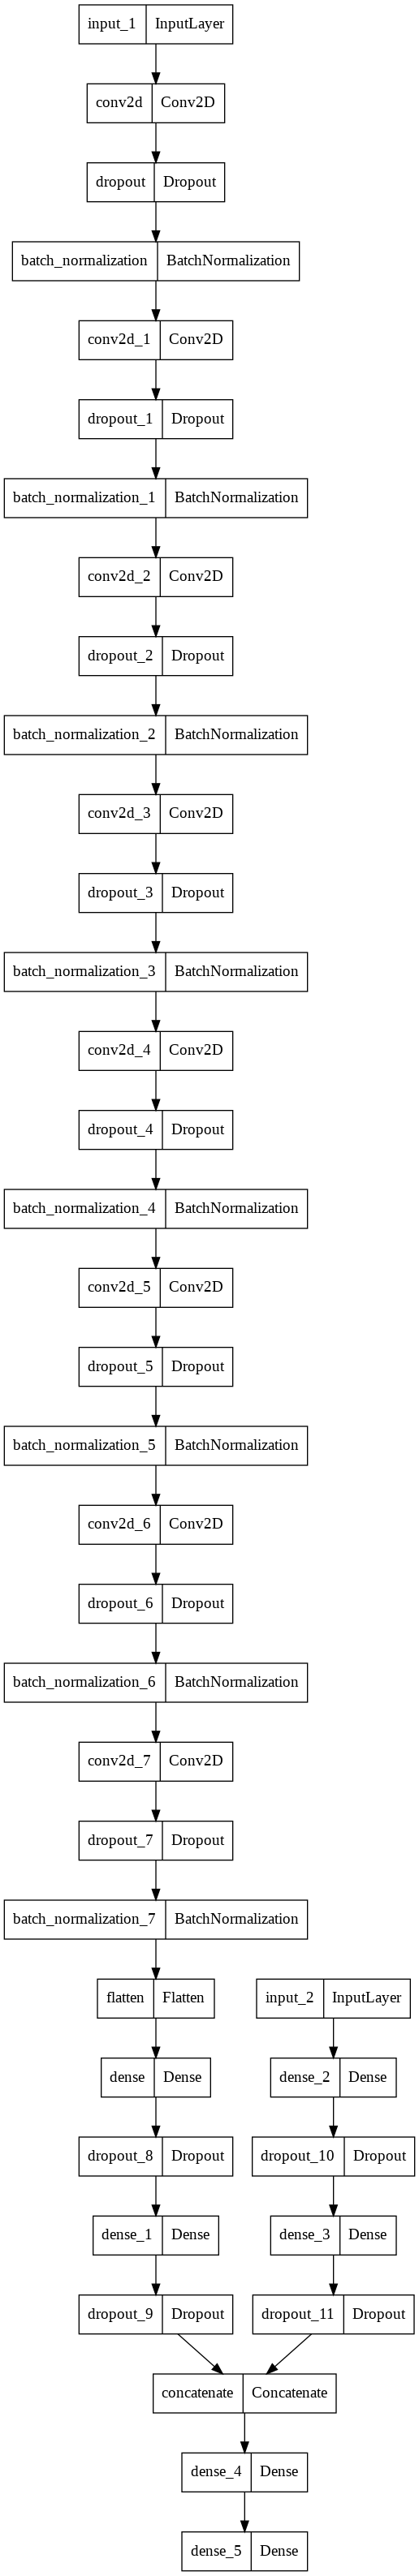

In [ ]:
model.summary()
plot_model(model)

In [ ]:
def img_prepro(image, training):
  image = image/255.0
  return image

def read_file(path):
  hf = None
  try:
    hf = h5py.File(path)
  except:
    print("error occured with file: " + path)
  return hf

def read_data(hf, training):
  images = hf.get('rgb')
  targets = hf.get('targets')
  data = []
  labels = []
  for image, measures in zip(images, targets):
    # Citim imaginea si o preprocessam
    image = img_prepro(image, training)
    speed = measures[10]/25.0 #Normalizam viteza cu viteza maxima din dataset
    data.append((image, speed))

    # Citim datele de iesire ale modelului
    steering = measures[0]
    acceleration = measures[1]
    brake = measures[2]
    if(measures[4] == 1):
      acceleration *= -1
    labels.append((steering, acceleration, brake))
  return data, labels

In [ ]:
def train_one_step(model, optimizer, data, labels, train_loss):
    '''
    Trains on a batch of data for one step.
    
    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        x (Tensor) -- training data
        y (Tensor) -- training labels
        train_loss (keras Loss) -- loss object for training
        train_accuracy (keras Metric) -- accuracy metric for training
    '''
    loss = 0
    with tf.GradientTape() as tape:
        # Run the model on input x to get predictions
        for x, y in zip(data, labels):
          predictions = model((np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)))
          # Compute the training loss using `train_loss`, passing in the true y and the predicted y
          loss += train_loss(y, predictions)

    tf.print("loss:", loss)
    # Using the tape and loss, compute the gradients on model variables using tape.gradient
    grads = tape.gradient(loss, model.trainable_weights)
    
    # Zip the gradients and model variables, and then apply the result on the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss

In [ ]:
@tf.function
def train(model, optimizer, epochs, device, train_path, train_loss, valid_path, val_loss):

    '''
    Performs the entire training loop. Prints the loss and accuracy per step and epoch.
    
    Args:
        model (keras Model) -- model
        optimizer (keras Optimizer) -- optimizer to use during training
        epochs (int) -- number of epochs
        train_path (path) -- the train path
        train_loss (keras Loss) -- loss function for training
        train_accuracy (keras Metric) -- accuracy metric for training
        valid_path (path) -- the val path
        val_loss (keras Loss) -- loss object for validation
        val_accuracy (keras Metric) -- accuracy metric for validation
    '''

    step = 0
    loss = 0.0
    for epoch in range(epochs):
      for filename in os.listdir(train_path):
        print(filename)
        hf = read_file(train_path + sep + filename)
        
        if hf != None:
          step += 1
          data, labels = read_data(hf, True)

          with tf.device(device_name=device):
              loss = train_one_step(model, optimizer, data, labels, train_loss)

      with tf.device(device_name=device):
        for filename in os.listdir(valid_path):
          #print(filename)
          hf = read_file(train_path + sep + filename)
          
          if hf != None:
            data, labels = read_data(hf, False)
            
            # Call the model on the batches of inputs x and get the predictions
            y_pred = model(data)
            loss = val_loss(labels, y_pred)
        
      # Print the validation loss and accuracy
      tf.print('val loss', loss)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002)
train_loss = tf.keras.losses.MeanSquaredError()
val_loss = tf.keras.losses.MeanSquaredError()
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'
epochs = 1

In [ ]:
train(model, optimizer, epochs, device, data_train, train_loss, data_val, val_loss)

data_05498.h5
data_06820.h5
data_03927.h5
data_04634.h5


KeyboardInterrupt: ignored

In [ ]:
device